# Multimodal Report Generation (from a Slide Deck)

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/multimodal/multimodal_report_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generator. The pipeline parses a slide deck and stores both text and image chunks. It generates a detailed response that contains interleaving text and images.

**NOTE**: This pipeline operates over the entire document and does not do retrieval, in order to retrieve the full context. You can of course explore adding a higher-level retrieval layer where you retrieve the relevant document(s) first before feeding to a multimodal model.

## Setup

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Setup Observability

We setup an integration with LlamaTrace (integration with Arize).

If you haven't already done so, make sure to create an account here: https://llamatrace.com/login. Then create an API key and put it in the `PHOENIX_API_KEY` variable below.

In [3]:
import os
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = "api_key=8744eb23620be64306c:ad4e7c0"
os.environ["PHOENIX_CLIENT_HEADERS"] = "api_key=8744eb23620be64306c:ad4e7c0"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"
  

In [4]:
!pip install -U llama-index-callbacks-arize-phoenix

In [5]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

PHOENIX_API_KEY = "8744eb23620be64306c:ad4e7c0"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

### Load Data

Here we load the [Conoco Phillips 2023 investor meeting slide deck](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).

In [6]:
# !mkdir data
# !mkdir data_images
!wget "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf" -O data/conocophillips.pdf

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import requests

url = "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf"
response = requests.get(url)

# Save the file
with open("data/conocophillips.pdf", "wb") as file:
    file.write(response.content)

print("File downloaded successfully.")


File downloaded successfully.


### Model Setup

Setup models that will be used for downstream orchestration.

In [9]:
!pip install llama_index


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.2 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 12.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/169.4 kB ? eta -:--:--
   --------------------------------------- 169.4/169.4 kB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/362.4 kB ? eta -:--:--
   --------------------------------------- 362.4/362.4 kB 23.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/295.8 kB ? eta -:--:--
   ---------------------------------------- 295.8/295.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/191.0 kB ? eta -:--:--
   --------------------------------------- 191.0/191.0 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.37.0
    Uninstalling openai-1.37.0:
      Successfully uninstalled openai-1.37.0


In [10]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large")
llm = OpenAI(model="gpt-4o")

Settings.embed_model = embed_model
Settings.llm = llm

## Use LlamaParse to Parse Text and Images

In this example, use LlamaParse to parse both the text and images from the document, using our multimodal mode (+ Sonnet 3.5).

This returns both the parsed document using Sonnet, but also the rendered image chunks saved locally.

In [1]:
import os

LLAMA_API_KEY = os.getenv("LLAMA_API_KEY")

In [2]:
LLAMA_API_KEY

'llx-KNQySBY7j1hQN4bJhVVtGcJfbkNBIbQ8qhdrR3rwgbrsrt4U'

In [3]:
from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    vendor_multimodal_model_name="anthropic-sonnet-3.5",
    api_key=LLAMA_API_KEY
)

In [5]:
# !pip install nest_asyncio

In [ ]:
# print(f"Parsing slide deck...")
# md_json_objs = parser.get_json_result("data/conocophillips.pdf")
# md_json_list = md_json_objs[0]["pages"]

In [6]:
import nest_asyncio
nest_asyncio.apply()

print(f"Parsing slide deck...")
md_json_objs = parser.get_json_result("data/conocophillips.pdf")
md_json_list = md_json_objs[0]["pages"]


Parsing slide deck...
Started parsing the file under job_id 6ad230ef-5154-4d83-930a-821b891c67b2


In [7]:
print(md_json_list[10]["md"])

# Commitment to Disciplined Reinvestment Rate

Disciplined Reinvestment Rate is the Foundation for Superior Returns on and of Capital, while Driving Durable CFO Growth

| Metric | Value |
|--------|-------|
| 10-Year Reinvestment Rate | ~50% |
| CFO CAGR 2024-2032 | ~6% |
| Mid-Cycle Planning Price | at $60/BBL WTI |

| Period | Industry Growth Focus | ConocoPhillips Strategy Reset | Reinvestment Rate |
|--------|------------------------|-------------------------------|-------------------|
| 2012-2016 | >100% Reinvestment Rate | - | ~$75/BBL WTI Average |
| 2017-2022 | - | <60% Reinvestment Rate | ~$63/BBL WTI Average |
| 2023E | - | - | at $80/BBL WTI |
| 2024-2028 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |
| 2029-2032 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |

[The image shows a bar chart depicting ConocoPhillips Average Annual Reinvestment Rate (%) over time, with historic rates in grey and projected rates in blue. The chart illustrates a decreasing 

In [8]:
print(md_json_list[1].keys())

dict_keys(['page', 'md', 'images', 'items'])


In [9]:
image_dicts = parser.get_images(md_json_objs, download_path="data_images")

> Image for page 1: [{'name': 'page-0.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page-1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page-2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page-3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page-4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page-5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page-6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 8: [{'name': 'page-7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 9: [{'name': 'page-8.jpg', 'height': 0,

## Setup and Build Index

In this section we create a set of nodes from the slide deck, one per page, and attach the corresponding rendered image file path as metadata for each parsed page chunk. 

We then build a simple summary index over the saved deck. **NOTE**: We could do vector indexing too, but here we want to produce comprehensive reports which oftentimes require access to the entire document.

#### Get Text Nodes

In [1]:
from llama_index.core.schema import TextNode
from typing import Optional

In [2]:
# get pages loaded through llamaparse
import re


def get_page_number(file_name):
    match = re.search(r"-page-(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0


def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [f for f in list(Path(image_dir).iterdir()) if f.is_file()]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

In [3]:
from copy import deepcopy
from pathlib import Path


# attach image metadata to the text nodes
def get_text_nodes(json_dicts, image_dir=None):
    """Split docs into nodes, by separator."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir) if image_dir is not None else None
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        chunk_metadata = {"page_num": idx + 1}
        if image_files is not None:
            image_file = image_files[idx]
            chunk_metadata["image_path"] = str(image_file)
        chunk_metadata["parsed_text_markdown"] = md_text
        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes

In [5]:
# this will split into pages
text_nodes = get_text_nodes(md_json_list, image_dir="data_images")

NameError: name 'docs_text' is not defined

In [14]:
print(text_nodes[10].get_content(metadata_mode="all"))

page_num: 11
image_path: data_images\6ad230ef-5154-4d83-930a-821b891c67b2-page-10.jpg
parsed_text_markdown: # Commitment to Disciplined Reinvestment Rate

Disciplined Reinvestment Rate is the Foundation for Superior Returns on and of Capital, while Driving Durable CFO Growth

| Metric | Value |
|--------|-------|
| 10-Year Reinvestment Rate | ~50% |
| CFO CAGR 2024-2032 | ~6% |
| Mid-Cycle Planning Price | at $60/BBL WTI |

| Period | Industry Growth Focus | ConocoPhillips Strategy Reset | Reinvestment Rate |
|--------|------------------------|-------------------------------|-------------------|
| 2012-2016 | >100% Reinvestment Rate | - | ~$75/BBL WTI Average |
| 2017-2022 | - | <60% Reinvestment Rate | ~$63/BBL WTI Average |
| 2023E | - | - | at $80/BBL WTI |
| 2024-2028 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |
| 2029-2032 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |

[The image shows a bar chart depicting ConocoPhillips Average Annual Reinvestment Rate

In [15]:
import os
from llama_index.core import (
    StorageContext,
    SummaryIndex,
    load_index_from_storage,
)

if not os.path.exists("storage_nodes_summary"):
    index = SummaryIndex(text_nodes)
    # save index to disk
    index.set_index_id("summary_index")
    index.storage_context.persist("./storage_nodes_summary")
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="storage_nodes_summary")
    # load index
    index = load_index_from_storage(storage_context, index_id="summary_index")

## Build Query Engine

We now use LlamaIndex abstractions to build a **structured query engine**. In contrast to a standard RAG query engine which just outputs plain text, here we define a structured output schema (`ReportOutput`), and attach it to the LLM. By using this structured LLM, the RAG query engine will output a structured output.

In [16]:
from llama_index.llms.openai import OpenAI
from pydantic.v1 import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))


system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""


llm = OpenAI(model="gpt-4o", system_prompt=system_prompt)
sllm = llm.as_structured_llm(output_cls=ReportOutput)

In [17]:
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=sllm,
    # response_mode="tree_summarize"
    response_mode="compact",
)

In [18]:
response = query_engine.query(
    "Give me a summary of the financial performance of the Alaska/International segment vs. the lower 48 segment"
)

The financial performance of ConocoPhillips' Alaska/International segment and the Lower 48 segment can be summarized as follows:

### Alaska/International Segment

- **Capital Expenditures**: The Alaska/International segment has planned capital expenditures of $3.7 billion in 2023, averaging $4.4 billion from 2024-2028, and $3.0 billion from 2029-2032.
- **Production**: Expected production is around 750 MBOED in 2023, increasing to an average of 870 MBOED from 2024-2028, and 1080 MBOED from 2029-2032.
- **Free Cash Flow (FCF)**: The segment is projected to generate $5.5 billion in FCF in 2023, with an average of $6.5 billion from 2024-2028, and $15 billion from 2029-2032.
- **Reinvestment Rate**: Over the next 10 years, the segment is expected to maintain a reinvestment rate of around 40% at $60/BBL WTI.

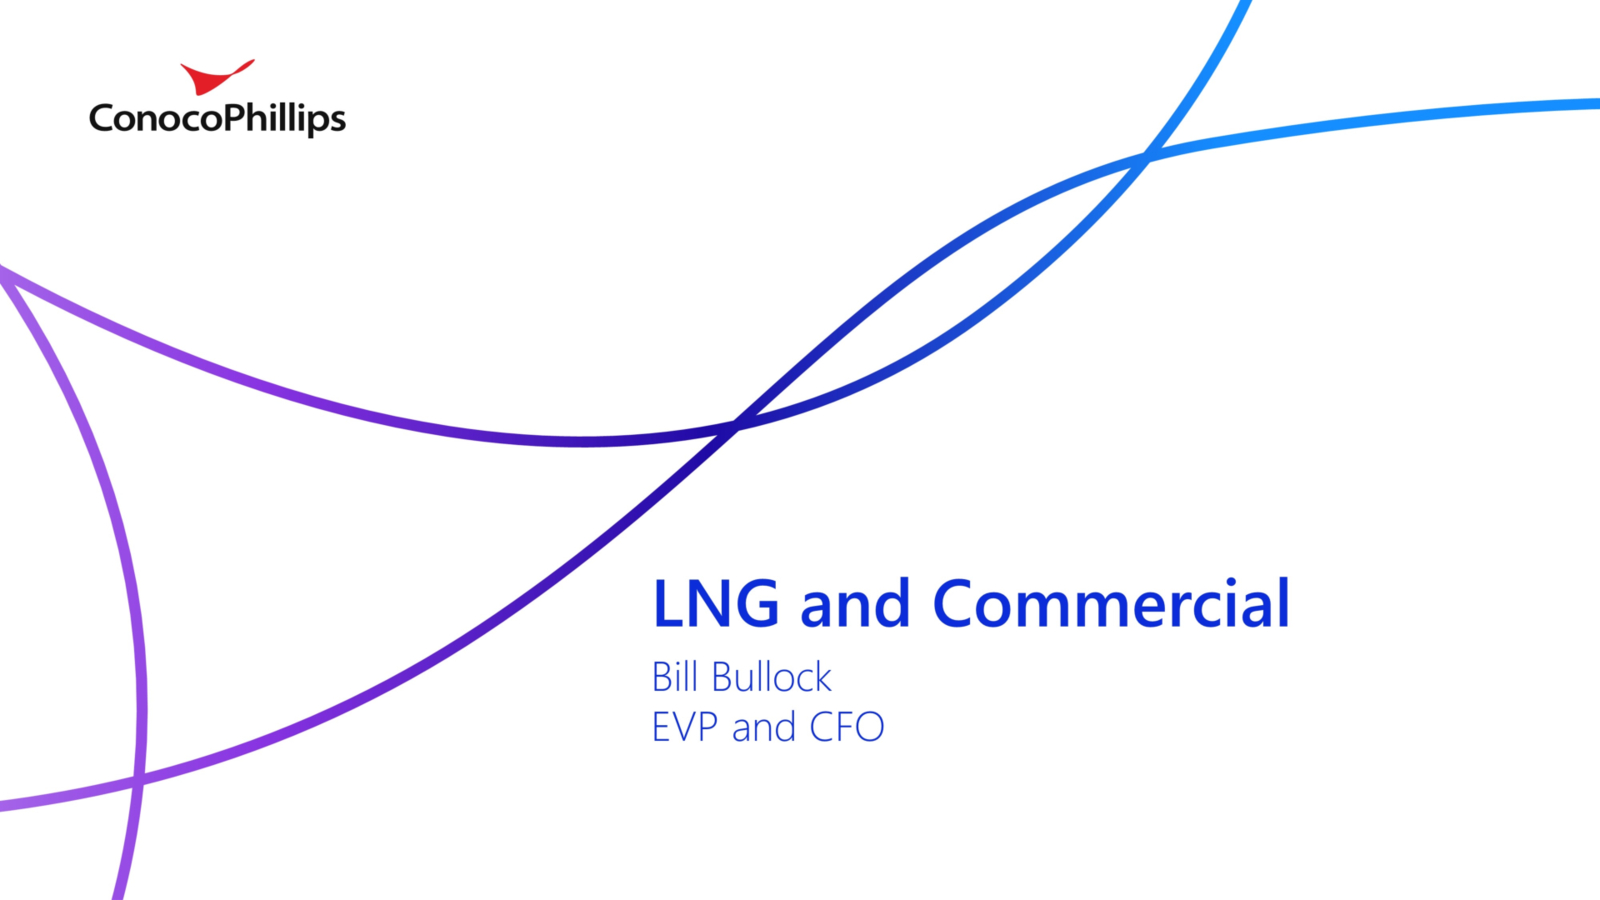

### Lower 48 Segment

- **Capital Expenditures**: The Lower 48 segment has planned capital expenditures of $6.3 billion in 2023, averaging $6.5 billion from 2024-2028, and $8.1 billion from 2029-2032.
- **Production**: Expected production is around 1050 MBOED in 2023, increasing to an average of 1220 MBOED from 2024-2028, and 1530 MBOED from 2029-2032.
- **Free Cash Flow (FCF)**: The segment is projected to generate $7 billion in FCF in 2023, with an average of $5.5 billion from 2024-2028, and $8 billion from 2029-2032.
- **Reinvestment Rate**: Over the next 10 years, the segment is expected to maintain a reinvestment rate of around 50% at $60/BBL WTI.

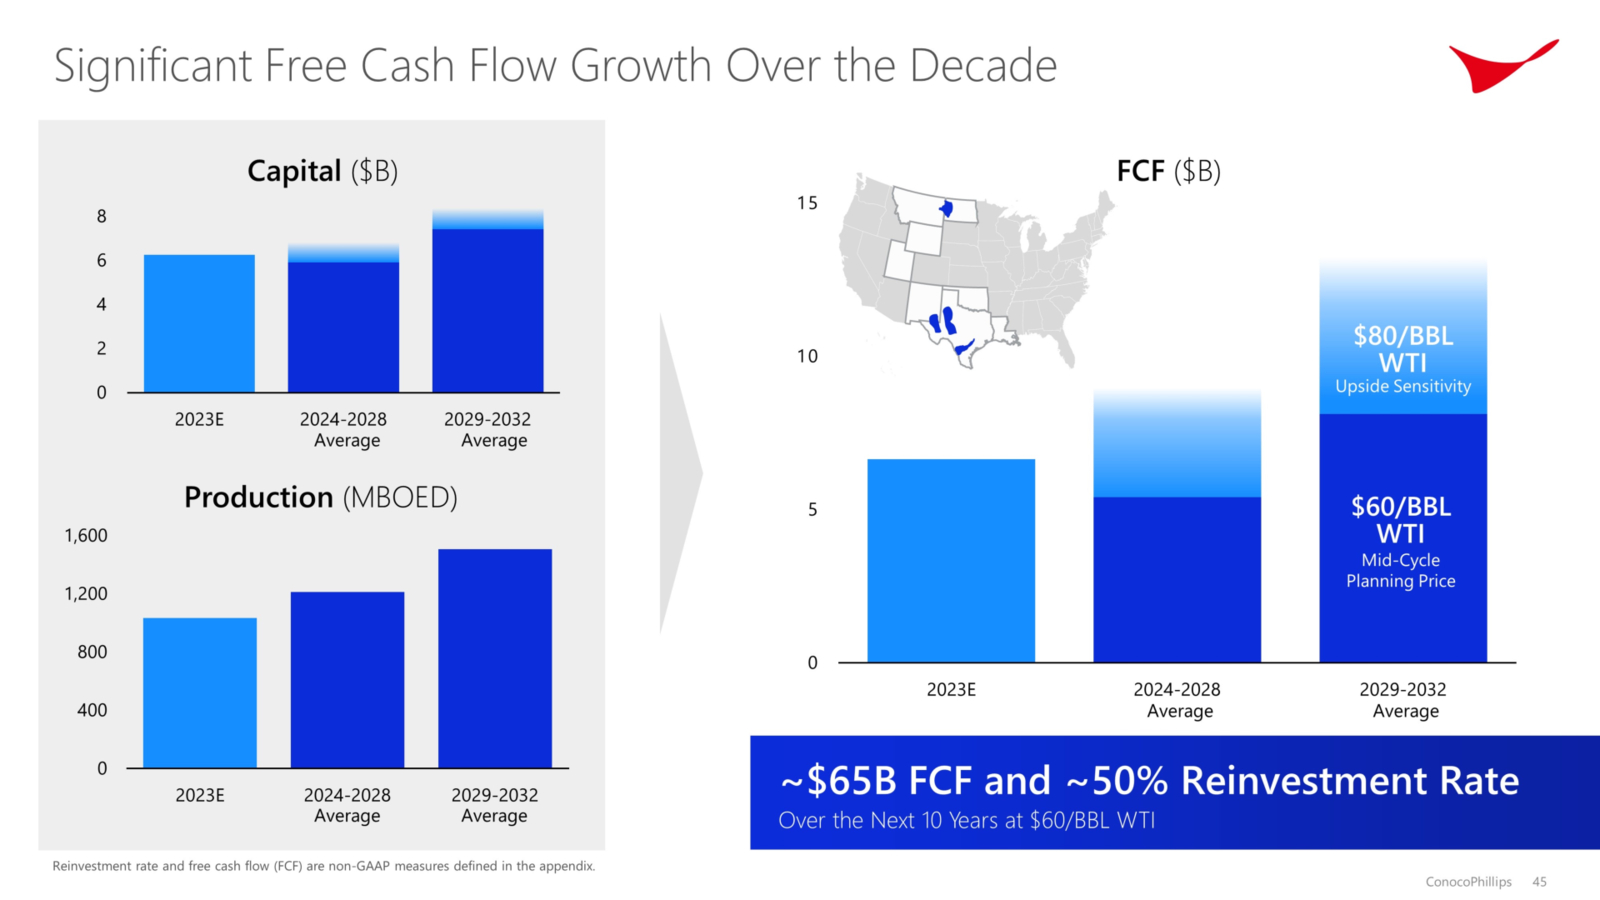

In [19]:
response.response.render()

In [20]:
response = query_engine.query(
    "Give me a summary of whether you think the financial projections are stable, and if not, what are the potential risk factors. "
    "Support your research with sources."
)

The financial projections for ConocoPhillips appear to be stable, supported by a comprehensive and well-structured plan that emphasizes consistent returns on and of capital, cash flow growth, and a strong balance sheet. The company has outlined a clear strategy to deliver superior returns through cycles, with a focus on disciplined investments, balance sheet strength, peer-leading distributions, and ESG excellence.

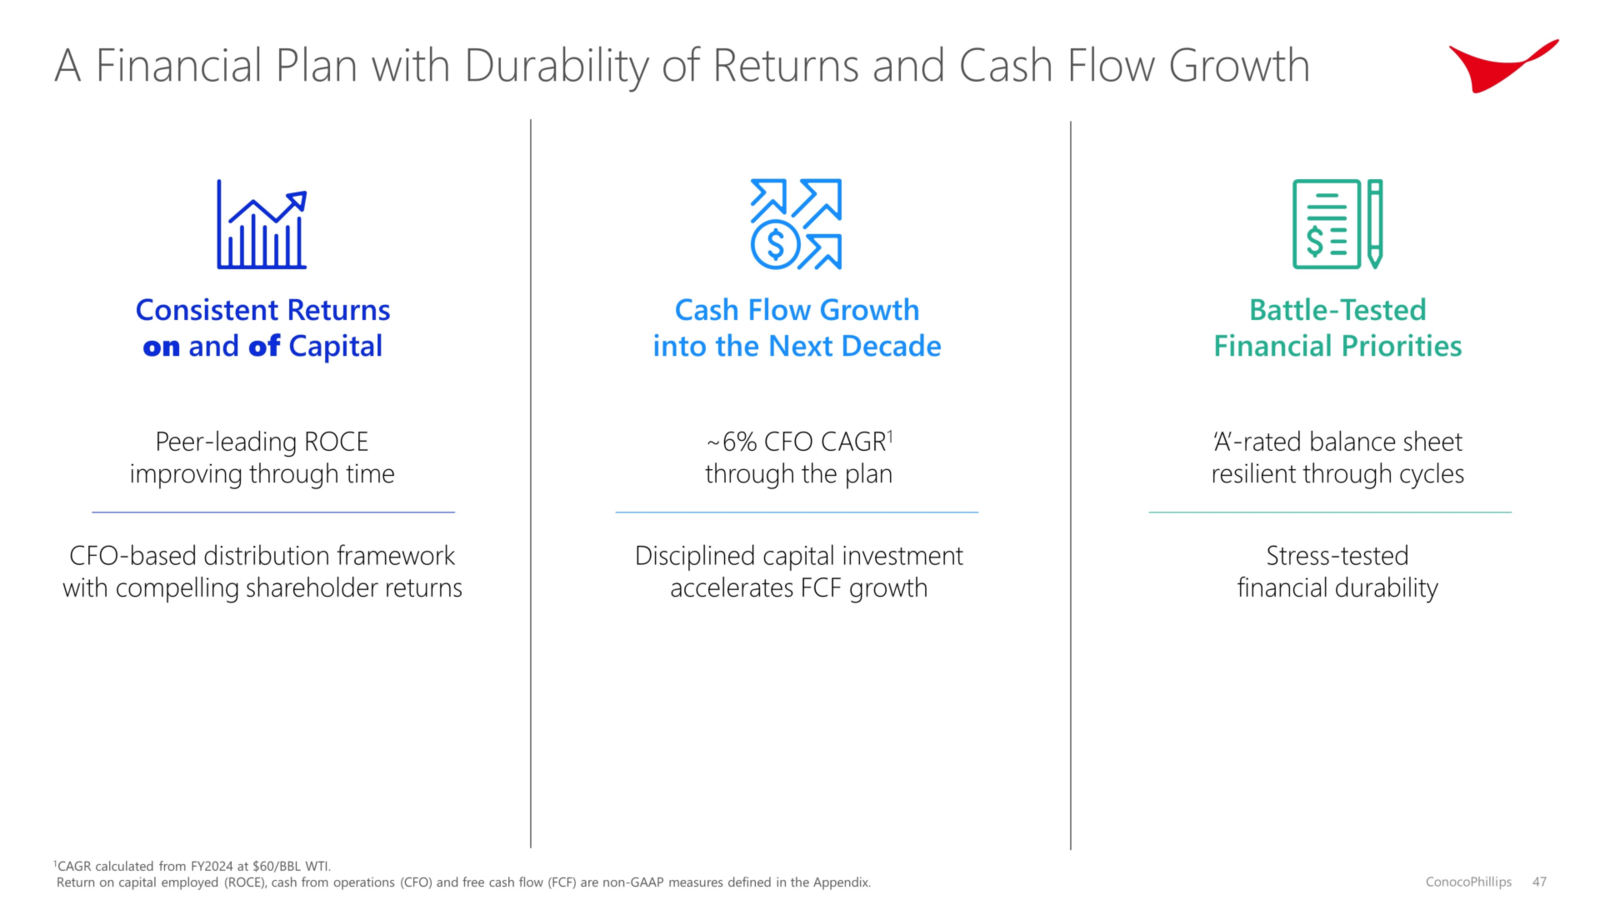

Key financial metrics indicate robust performance and growth potential. The company projects a compound annual growth rate (CAGR) of approximately 6% for cash from operations (CFO) and 11% for free cash flow (FCF) from 2024 to 2032 at a mid-cycle planning price of $60 per barrel of West Texas Intermediate (WTI). Additionally, ConocoPhillips aims to maintain a low free cash flow breakeven price of around $35 per barrel of WTI, which provides a cushion against price volatility.

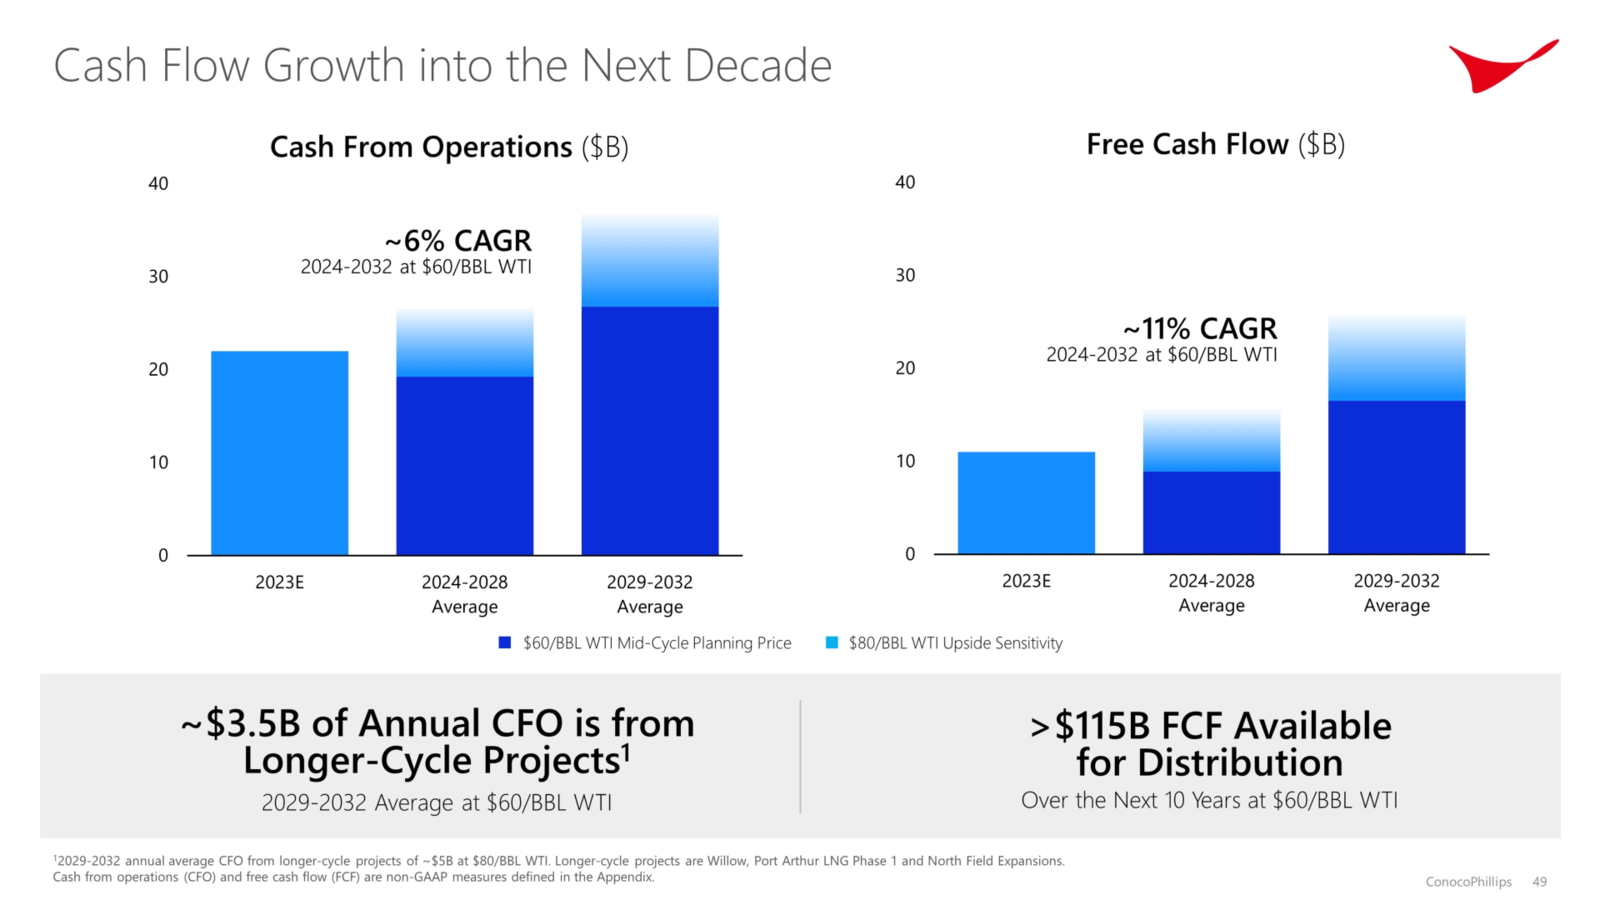

The company's financial plan is designed to be resilient even under stress test scenarios, such as a two-year period with oil prices at $40 per barrel of WTI. ConocoPhillips plans to hold strategic, reserve, and operating cash to ensure it can maintain its capital program, meet distribution commitments, and avoid additional debt during low-price cycles.

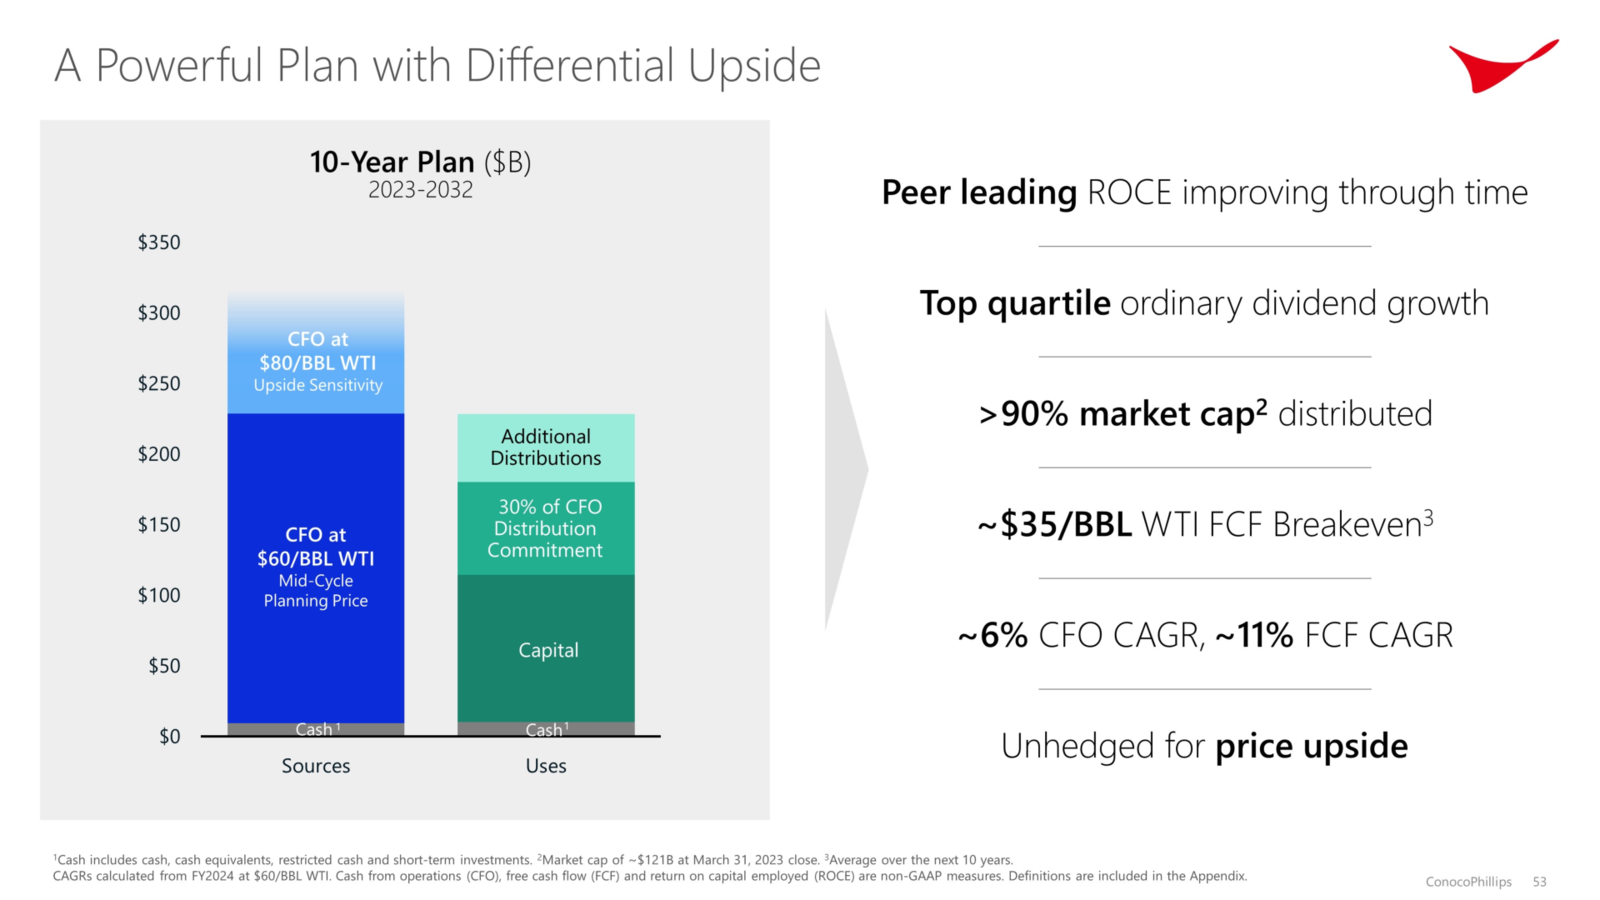

However, there are potential risk factors that could impact the stability of these financial projections. These include changes in commodity prices, global and regional demand and supply dynamics, geopolitical events, regulatory changes, and environmental concerns. For instance, prolonged declines in oil and gas prices, disruptions due to geopolitical conflicts, or stringent regulatory measures addressing climate change could adversely affect the company's financial performance.

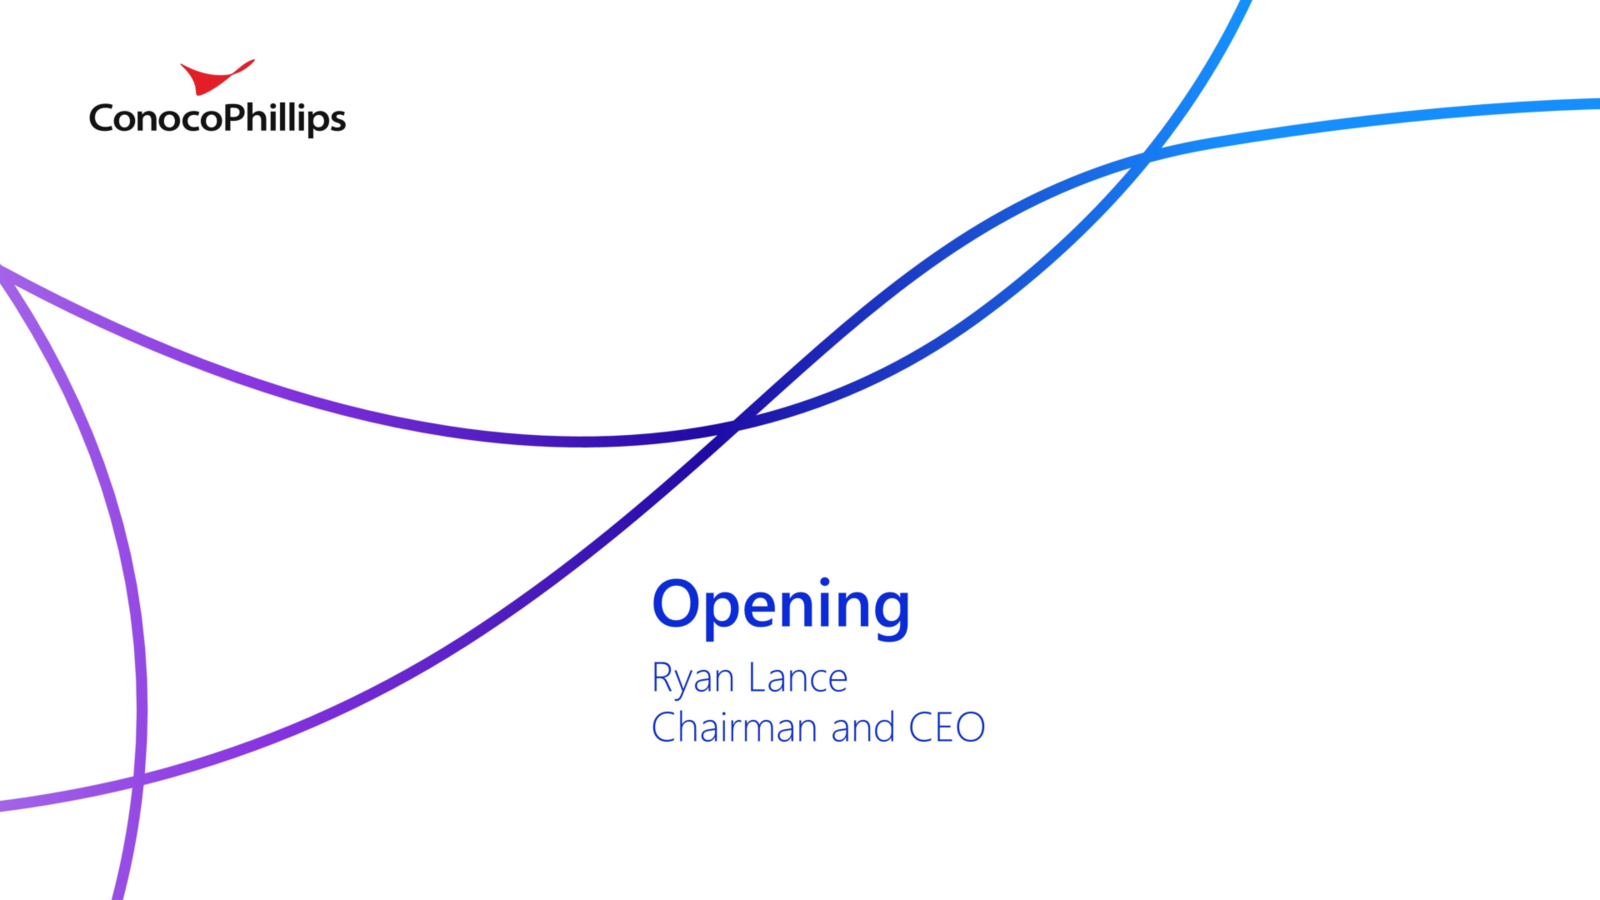

In summary, while ConocoPhillips' financial projections appear stable and well-supported by a robust plan, the company remains exposed to various external risk factors that could potentially impact its financial stability. Continuous monitoring of these risks and adaptive strategies will be crucial for maintaining financial resilience.

In [21]:
response.response.render()